$$\hat{S(t)} = \prod_{i=0}^t \left(1 - \frac{d_i}{n_i}\right), \;\; \text{for all $t$}$$

$$P( T = 0 ) \approx \frac{d_0}{n_0}$$

$$ \Rightarrow P( T > 0 ) \approx \left(1 - \frac{d_0}{n_0} \right) $$

$$ P( T > 1 ) = P( T > 1 \;|\; T > 0 )P( T > 0 ) \\ \approx \left(1 - \frac{d_1}{n_1}\right)\left(1 - \frac{d_0}{n_0}\right)$$

### Handle Imbalanced Dataset
For common cases such as ads clickthrough log, the dataset is extremely imbalanced. This can affect the training of xgboost model, and there are two ways to improve it.

If you care only about the ranking order (AUC) of your prediction
Balance the positive and negative weights, via scale_pos_weight
Use AUC for evaluation
If you care about predicting the right probability
In such a case, you cannot re-balance the dataset
In such a case, set parameter max_delta_step to a finite number (say 1) will help convergence

### Control Overfitting
When you observe high training accuracy, but low tests accuracy, it is likely that you encounter overfitting problem.

There are in general two ways that you can control overfitting in xgboost

The first way is to directly control model complexity
This include max_depth, min_child_weight and gamma
The second way is to add randomness to make training robust to noise
This include subsample, colsample_bytree
You can also reduce stepsize eta, but needs to remember to increase num_round when you do so.

In [2]:
from __future__ import division
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns
sns.set(style='whitegrid')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)

In [3]:
churn = pd.read_csv('/Users/marvinbertin/Desktop/tmp/churn.csv', )
col_names = churn.columns.tolist()
print "number of features: ", len(col_names)
print col_names

number of features:  21
['State', 'Account Length', 'Area Code', 'Phone', "Int'l Plan", 'VMail Plan', 'VMail Message', 'Day Mins', 'Day Calls', 'Day Charge', 'Eve Mins', 'Eve Calls', 'Eve Charge', 'Night Mins', 'Night Calls', 'Night Charge', 'Intl Mins', 'Intl Calls', 'Intl Charge', 'CustServ Calls', 'Churn?']


In [4]:
churn.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [5]:
print "Should we drop the 'Phone' feature? ", len(churn["Phone"].unique()) == len(churn)

Should we drop the 'Phone' feature?  True


In [6]:
churn.drop("Phone", axis = 1, inplace=True)

In [7]:
churn_map = {"True.": 1, "False.": 0}
churn["Churn?"] = churn[["Churn?"]].applymap(lambda x: churn_map[x])

# Don't need the following if using tree based algorithms
# plan_map = {"yes": 1, "no": 0}
# churn["Int'l Plan"] = churn[["Int'l Plan"]].applymap(lambda x: plan_map[x])
# churn["VMail Plan"] = churn[["VMail Plan"]].applymap(lambda x: plan_map[x])

In [8]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3333 entries, 0 to 3332
Data columns (total 20 columns):
State             3333 non-null object
Account Length    3333 non-null int64
Area Code         3333 non-null int64
Int'l Plan        3333 non-null object
VMail Plan        3333 non-null object
VMail Message     3333 non-null int64
Day Mins          3333 non-null float64
Day Calls         3333 non-null int64
Day Charge        3333 non-null float64
Eve Mins          3333 non-null float64
Eve Calls         3333 non-null int64
Eve Charge        3333 non-null float64
Night Mins        3333 non-null float64
Night Calls       3333 non-null int64
Night Charge      3333 non-null float64
Intl Mins         3333 non-null float64
Intl Calls        3333 non-null int64
Intl Charge       3333 non-null float64
CustServ Calls    3333 non-null int64
Churn?            3333 non-null int64
dtypes: float64(8), int64(9), object(3)
memory usage: 546.8+ KB


In [9]:
kmf = KaplanMeierFitter()

In [10]:
T = churn["Account Length"]
C = churn["Churn?"]
kmf.fit(T, event_observed=C )

<lifelines.KaplanMeierFitter: fitted with 3333 observations, 2850 censored>

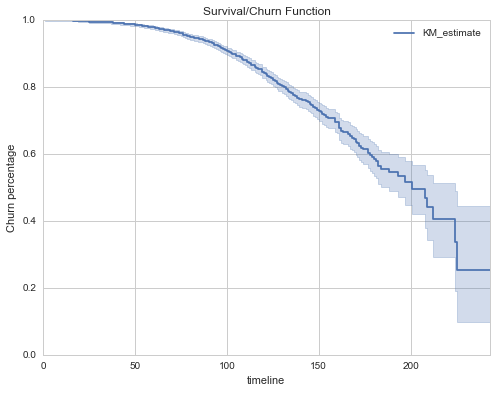

In [11]:
# average churn percentage per timeline
kmf.plot()
plt.title("Survival/Churn Function")
plt.ylabel("Churn percentage")
#sns.despine()
plt.show()

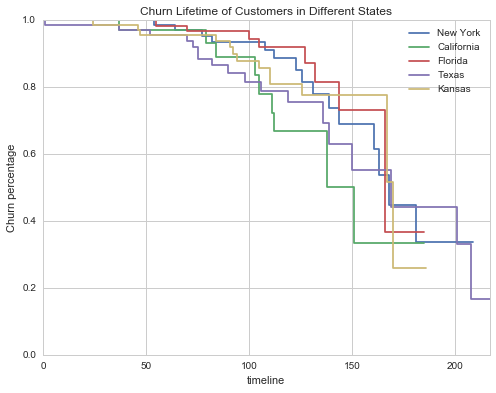

In [12]:
ax = plt.subplot(111)

state_list = [("NY", "New York"),
              ("CA", "California"),
              ("FL", "Florida"),
              ("TX", "Texas"),
              ("KS", "Kansas")]


for state, name in state_list:
    state_idx = churn["State"] == state
    kmf.fit(T[state_idx], event_observed=C[state_idx], label=name)
    kmf.plot(ax=ax, ci_show=False)

plt.ylim(0,1)
plt.ylabel("Churn percentage")
plt.title("Churn Lifetime of Customers in Different States")
plt.show()

In [13]:
# Median user stay
kmf.median_

170.0

In [14]:
#pd.pivot_table(churn, index=["Churn?"], aggfunc=[len])

In [15]:
# df1 = pd.DataFrame(churn["Churn?"], columns=["Churn?"])
# df1.rename(columns= {"Churn?":"Churn"}, inplace=True)

# reverse_map = {0:1, 1:0}
# df1["NotChurn"] = df1[["Churn"]].applymap(lambda x: reverse_map[x])

In [16]:
#sns.barplot(x = ["Churn", "NotChurn"],  data = df1)

/Users/marvinbertin/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


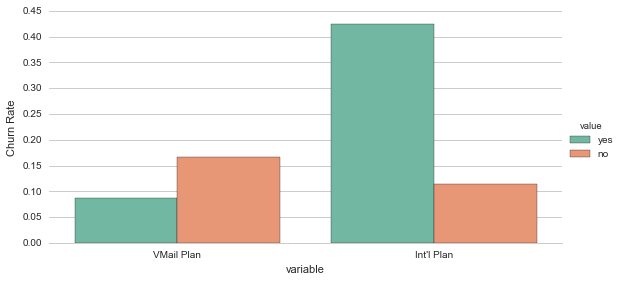

In [17]:
# Create a new temporary dataframe to help us plot these variables.
df1 = pd.melt(churn, id_vars=['Churn?'], value_vars=["VMail Plan","Int'l Plan"], var_name='variable' )

# Create a factorplot
g = sns.factorplot( x="variable", y="Churn?", hue='value', data=df1, size=4, aspect=2, kind="bar", palette="Set2", ci=None )
g.despine(left=True)
g.set_ylabels("Churn Rate")
plt.show()

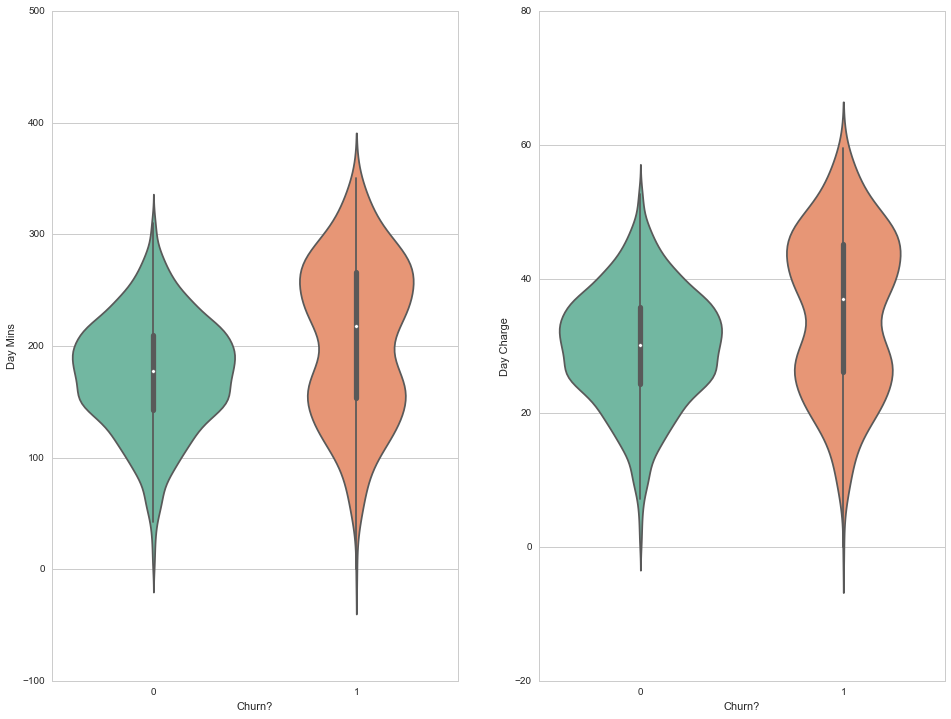

In [21]:
plt.figure(figsize=(16, 12))

for e, column in enumerate(['Day Mins','Day Charge']):
    plt.subplot(1, 2, e + 1)
    sns.violinplot( data=churn, x='Churn?', y=column, palette="Set2")

In [21]:
churn['DayMin_Call'] = churn['Day Mins'] / churn['Day Calls']
churn['EveMin_Call'] = churn['Eve Mins'] / churn['Eve Calls']
churn['NightMinP_Call'] = churn['Night Mins'] / churn['Night Calls']
churn['DayPrice_Min'] = churn['Day Charge'] / churn['Day Mins']
churn['EvePrice_Min'] = churn['Eve Charge'] / churn['Eve Mins']
churn['NightPrice_Min'] = churn['Night Charge'] / churn['Night Mins']

In [22]:
new_features = ['DayMin_Call', 'EveMin_Call', 'NightMinP_Call', 'DayPrice_Min', 'EvePrice_Min', 'NightPrice_Min']
for feature in new_features:
    churn.loc[churn[feature].isnull(), feature] = 0

In [23]:
churn['NoVMail Messages'] = np.where(churn['VMail Message'] < 1, "yes", "no")

In [24]:
y = churn["Churn?"].values

churn.drop("Churn?", axis=1, inplace=True)

X = churn.values

In [25]:
X[0,:]

array(['KS', 128, 415, 'no', 'yes', 25, 265.1, 110, 45.07, 197.4, 99,
       16.78, 244.7, 91, 11.01, 10.0, 3, 2.7, 1, 2.41, 1.993939393939394,
       2.689010989010989, 0.1700113164843455, 0.08500506585612969,
       0.044993870044953005, 'no'], dtype=object)

In [29]:
from sklearn.cross_validation import cross_val_score
from xgboost import XGBClassifier
from bayes_opt import BayesianOptimization

ImportError: No module named xgboost

In [ ]:
def load_data(path_train = DATA_TRAIN_PATH, path_test = DATA_TEST_PATH):
    train = pd.read_csv(path_train)
    train_labels = [int(v[-1])-1 for v in train.target.values]
    train_ids = train.id.values
    train = train.drop('id', axis=1)
    train = train.drop('target', axis=1)

    test = pd.read_csv(path_test)
    test_ids = test.id.values
    test = test.drop('id', axis=1)

    return np.array(train, dtype=float), \
           np.array(train_labels), \
           np.array(test, dtype=float),\
           np.array(train_ids), \
            np.array(test_ids)

In [ ]:
def xgboostcv(max_depth,
              learning_rate,
              n_estimators,
              gamma,
              min_child_weight,
              max_delta_step,
              subsample,
              colsample_bytree,
              silent =True,
              nthread = -1,
              seed = 1234):
    return cross_val_score(XGBClassifier(max_depth = int(max_depth),
                                         learning_rate = learning_rate,
                                         n_estimators = int(n_estimators),
                                         silent = silent,
                                         nthread = nthread,
                                         gamma = gamma,
                                         min_child_weight = min_child_weight,
                                         max_delta_step = max_delta_step,
                                         subsample = subsample,
                                         colsample_bytree = colsample_bytree,
                                         seed = seed,
                                         objective = "binary:logistic"),
                           train,
                           labels,
                           "log_loss",
                           cv=5).mean()

In [ ]:
train, labels, test, _, _ = load_data()

In [ ]:
xgboostBO = BayesianOptimization(xgboostcv,
                                     {'max_depth': (5, 10),
                                      'learning_rate': (0.01, 0.3),
                                      'n_estimators': (50, 1000),
                                      'gamma': (1., 0.01),
                                      'min_child_weight': (2, 10),
                                      'max_delta_step': (0, 0.1),
                                      'subsample': (0.7, 0.8),
                                      'colsample_bytree' :(0.5, 0.99)
                                     })

In [ ]:
xgboostBO.maximize()
print('-'*53)

print('Final Results')
print('XGBOOST: %f' % xgboostBO.res['max']['max_val'])